In [3]:
!nvidia-smi

Fri Nov 20 11:23:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 42%   63C    P2   166W / 280W |  20896MiB / 24220MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 80%   87C    P2   226W / 280W |  19108MiB / 24220MiB |     86%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [1]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim
from torchvision import models


sys.path.append('/home/ironman/abhishek/AliProducts/architectures/')
sys.path.append('/home/ironman/abhishek/AliProducts/Helper/')
from dataloader import mydataset, create_prime_dict 
from trainer_cutmix import train, test_classify, eval_classify
from resnet_models import ResNet,Bottleneck
from Load_model import load
from plot_curves import plot_loss, plot_acc

In [2]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


**Dataloading Scheme**

In [3]:
trainlist = '/home/ironman/abhishek/AliProducts/Newlist/NEW_train_list1.txt'
validlist = '/home/ironman/abhishek/AliProducts/Newlist/NEW_valid_list1.txt'

In [4]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  50030


In [5]:
# f = open(trainlist)
# s=f.readlines()

In [6]:
# from PIL import Image
# h=[]
# print(len(s))
# tlist = []
# for line in s:
    
#     path,upc = line[:-1].split(',')
#     i = '/media/Duamutef/abhishek/AliProducts/'+path.split('haoc/')[1]  
#     image = Image.open(i, mode='r')

#     if image.mode !='RGB':
#         h.append(image.size)
      
#     if image.mode =='RGB':
#         tlist.append(i+','+upc+'\n')
    
#     image.close()

# f.close()
# len(tlist)

In [7]:
# f1 = open('/home/ironman/abhishek/AliProducts/Newlist/NEW_train_list1.txt','w')
# for line in tlist:
#     f1.write(line)
# f1.close()

In [8]:
# f = open(validlist)
# s=f.readlines()

# h1=[]
# print(len(s))
# vallist = []
# for line in s:
    
#     path,upc = line[:-1].split(',')
#     i = '/media/Duamutef/abhishek/AliProducts/'+path.split('haoc/')[1]  
#     image = Image.open(i, mode='r')

#     if image.mode !='RGB':
#         h.append(image.size)
        
#     if image.mode =='RGB':
#         vallist.append(i+','+upc+'\n')
    
#     image.close()

# f.close()
# len(vallist)

In [9]:
# f2 = open('/home/ironman/abhishek/AliProducts/Newlist/NEW_valid_list1.txt','w')
# for line in vallist:
#     f2.write(line)
# f2.close()

In [5]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 128, num_workers=16,pin_memory=True)

**Model Definition**

In [6]:
model = models.resnext101_32x8d(pretrained = False, num_classes = 50030)

model = nn.DataParallel(model,device_ids=[4,5,6,7]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

**Hyperparameters**

In [8]:
## Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 25, gamma = 0.1)

# Epochs
num_Epochs = 90

beta=1

cutmix_prob = 1

In [10]:
modelname = 'NewData_Apro_AA_Cutmix_ResNeXt101_32x8d'
modelpath = '/home/ironman/abhishek/saved_model_checkpoints/AliProducts/'+modelname

In [15]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler, modelpath, writer, device=device, epochs = num_Epochs)

writer.flush()
writer.close()

loss 10.929397249221802
loss 21.754922943115233
loss 32.574211530685425
loss 43.39178409576416
loss 54.208316020965576
loss 65.02278270721436
loss 75.8364190673828
loss 86.6492978477478
loss 97.46004779815674
loss 108.26989413261414
loss 119.07832690238952
loss 129.88569869041442
loss 140.68724915504455
loss 151.4813890838623
loss 162.26945992469788
loss 173.0497418785095
loss 183.82717909812928
loss 194.59761132240294
loss 205.3571516418457
loss 216.11430557250978
loss 226.86092781066895
loss 237.59843144416809
loss 248.33528819084168
loss 259.0655483150482
loss 269.7880341053009
loss 280.5086734867096
loss 301.92041845321654
loss 312.62251637458803
loss 323.3181109046936
loss 334.00693050384524
loss 344.6918183422089
loss 355.36865070343015
loss 366.035722618103
loss 376.6973275756836
loss 387.36040234565735
loss 398.0061912155151
loss 408.6419890880585
loss 419.2708703041077
loss 429.90141414642335
loss 440.52380516052244
loss 451.13935965538025
loss 461.7413053894043
loss 472.34018

loss 15.497459361553192
loss 20.770117037296295
loss 26.008161036968232
loss 31.222968533039094
loss 36.34592840194702
loss 41.710502979755404
loss 46.95762809514999
loss 52.16895679950714
loss 57.496606152057645
loss 62.566491112709045
loss 67.86687086343765
loss 73.21528353691102
loss 78.44486744642258
loss 83.77568132400512
loss 89.0597852063179
loss 94.33073147535325
loss 99.66142205953598
loss 104.99925758123398
loss 110.23215136766434
loss 115.54246727228164
loss 120.88569724082947
loss 126.07772734642029
loss 131.293906621933
loss 136.71160546541213
loss 142.03923149108886
loss 147.29050760746003
loss 152.54488394498824
loss 157.77047148942947
loss 163.10518704175948
loss 168.3875400018692
loss 173.64060131549834
loss 178.91546322107314
loss 184.1096124100685
loss 189.27245883703233
loss 194.48256667613984
loss 199.68872567415238
loss 204.92214617729186
loss 210.16201719284058
loss 215.4027048587799
loss 220.6067267179489
loss 226.0709567642212
loss 231.31496007680892
Epoch:  8


loss 31.209337882995605
loss 35.891246590614315
loss 40.406964058876035
loss 44.936985609531405
loss 49.50563185930252
loss 54.14712074279785
loss 58.66491922855377
loss 63.16310787200928
loss 67.73422292470931
loss 72.34961113214493
loss 77.02533833742142
loss 81.7070197224617
loss 86.3510291481018
loss 90.92963228464127
loss 95.57065836668015
loss 100.1942339682579
loss 104.79448829889297
loss 109.52940635442734
loss 114.12250260829926
loss 118.75865366458893
loss 123.4761274933815
loss 127.97406979799271
loss 132.65683878183364
loss 137.32205793619156
loss 141.83278092861175
loss 146.45358692884446
loss 151.06675657987594
loss 155.75544808149337
loss 160.41811363697053
loss 165.12246846675873
loss 169.8114071202278
loss 174.45005273103715
loss 179.16253487348555
loss 183.89548157453538
loss 188.59483250141145
loss 193.31634215593337
loss 198.00640567302705
loss 202.70370172977448
Epoch:  15
Training loss =  4.606678881751357
Validation Loss: 1.5695	Top 1 Validation Accuracy: 0.6715	

loss 38.26924916148186
loss 42.697693907022476
loss 47.11066486001015
loss 51.52251439929009
loss 55.92132270693779
loss 60.33581228375435
loss 64.66895923018456
loss 69.04861928462982
loss 73.29504245758056
loss 77.73316478729248
loss 82.20892670869827
loss 86.64542171001435
loss 91.10229610681534
loss 95.55691867589951
loss 100.11491479873658
loss 104.54474719762803
loss 109.05619847297669
loss 113.45229878425599
loss 118.01413089752197
loss 122.51918726682663
loss 126.98522031068802
loss 131.58546329259872
loss 136.02362464189528
loss 140.47943006515504
loss 145.0608589911461
loss 149.589613468647
loss 154.15824872016907
loss 158.60558466434478
loss 163.11323462724687
loss 167.61254764080047
loss 172.23379989624024
loss 176.7866801595688
loss 181.1695425963402
loss 185.66557757616044
loss 190.16984147310257
loss 194.59918643713
Epoch:  22
Training loss =  4.424755912966908
Validation Loss: 1.4498	Top 1 Validation Accuracy: 0.6978	 Top 5 Validation Accuracy: 0.9110
loss 4.24470829725

loss 37.90208057045937
loss 40.83367502450943
loss 43.70565865278244
loss 46.60970752358437
loss 49.46948240280151
loss 52.3632656621933
loss 55.320475754737856
loss 58.28649077653885
loss 61.28649897694588
loss 64.1960612499714
loss 67.11724934458732
loss 70.06665532827377
loss 73.0618589758873
loss 76.10833208441734
loss 78.98527953267097
loss 82.01469027400017
loss 85.11183138608932
loss 87.8894580066204
loss 90.75431931972504
loss 93.67554092049599
loss 96.60903502583504
loss 99.4691258406639
loss 102.36995911955833
loss 105.3359719991684
loss 108.23646250128746
loss 111.21786539912223
loss 114.16545184135437
loss 117.1703672158718
loss 120.01424122214317
loss 122.96647049307823
loss 125.80624537706375
loss 128.77355819225312
Epoch:  29
Training loss =  2.929318895923279
Validation Loss: 0.6717	Top 1 Validation Accuracy: 0.8349	 Top 5 Validation Accuracy: 0.9778
loss 2.7644071161746977
loss 5.594280009269714
loss 8.42893278837204
loss 11.219825687408447
loss 14.06092323064804
loss 

loss 45.67476657152176
loss 48.418527530431746
loss 51.104400247335434
loss 53.84021721839905
loss 56.60169942140579
loss 59.28528546631336
loss 62.00195770561695
loss 64.74788804590702
loss 67.45308248698711
loss 70.24745335400104
loss 72.99458191633225
loss 75.7723473227024
loss 78.47130166590213
loss 81.21963430583477
loss 83.96171811759471
loss 86.77840594351292
loss 89.5064079350233
loss 92.21410917699338
loss 94.89904262959958
loss 97.64159875452519
loss 100.41261889517307
loss 105.8934218376875
loss 108.64275112450123
loss 111.36711986780166
loss 114.04922256946564
loss 116.7903865134716
loss 119.53111822962761
Epoch:  36
Training loss =  2.7177383076455692
Validation Loss: 0.6178	Top 1 Validation Accuracy: 0.8417	 Top 5 Validation Accuracy: 0.9796
loss 2.568167542219162
loss 5.214834780693054
loss 7.870732927918434
loss 13.259012675881387
loss 15.798609568476676
loss 18.468082496523856
loss 21.21590773999691
loss 23.835726373791694
loss 26.56981711566448
loss 29.35826560676098


loss 65.84628677546978
loss 68.4479652774334
loss 71.10536099135875
loss 73.8350112324953
loss 76.55734017431736
loss 79.21884930074215
loss 81.96284476578235
loss 84.68559818327427
loss 87.38090904176235
loss 90.04965003430843
loss 92.72997390091419
loss 95.41157945454121
loss 98.14454315304756
loss 100.84246354281902
loss 103.52413902163505
loss 106.22655855596065
loss 108.88757456004619
loss 111.60711936473847
loss 114.33859100341797
loss 116.94063013195992
Epoch:  43
Training loss =  2.6583213233159637
Validation Loss: 0.6335	Top 1 Validation Accuracy: 0.8374	 Top 5 Validation Accuracy: 0.9794
loss 2.595043321847916
loss 5.2170219898223875
loss 7.635602994561196
loss 10.265859306454658
loss 12.798393484354019
loss 15.395794385075568
loss 18.09053598344326
loss 20.662043261528016
loss 23.31669985473156
loss 25.975637483000757
loss 28.56074731528759
loss 31.13931814968586
loss 33.745672369003294
loss 36.37368000149727
loss 38.892500956058505
loss 41.57852087020874
loss 44.26454105854

loss 74.89277774870396
loss 77.54442899405956
loss 80.16735058367253
loss 82.7943795055151
loss 85.4713058435917
loss 88.09261323451996
loss 90.77033429145813
loss 93.39368955433369
loss 96.11787779688835
loss 98.75661636173726
loss 101.31262874424458
loss 103.96311559319496
loss 106.59576551437378
loss 109.28219450235366
loss 111.99024011135101
loss 114.58450907111168
Epoch:  50
Training loss =  2.6053315539667787
Validation Loss: 0.6838	Top 1 Validation Accuracy: 0.8380	 Top 5 Validation Accuracy: 0.9783
loss 2.5318247121572495
loss 4.9665745288133625
loss 7.2927101659774785
loss 9.755985733270645
loss 12.178153026103974
loss 14.480857944488525
loss 16.83017945766449
loss 19.159904502630233
loss 21.502991785407065
loss 23.79564769089222
loss 26.085314978957175
loss 30.82130898952484
loss 33.19645878791809
loss 35.54029342949391
loss 37.83542161226273
loss 40.16856060087681
loss 42.47323167622089
loss 44.80263684809208
loss 47.072119345068934
loss 49.45823809325695
loss 51.75526881515

loss 72.16702068626881
loss 74.35210218846798
loss 76.57045969963073
loss 78.73428349256515
loss 80.8826809823513
loss 83.01938785672188
loss 85.18008964538575
loss 87.31121177136897
loss 89.49775310575961
loss 91.70685376763343
loss 93.85515528082847
Epoch:  57
Training loss =  2.133955674088883
Validation Loss: 0.5025	Top 1 Validation Accuracy: 0.8597	 Top 5 Validation Accuracy: 0.9851
loss 2.0816297924518583
loss 4.162449315786362
loss 6.290139870643616
loss 8.450630774199963
loss 10.501224434673786
loss 12.608449474275112
loss 14.70483366459608
loss 16.88568266004324
loss 19.016090667545797
loss 21.106310916244983
loss 23.207689813673497
loss 25.373729245960714
loss 27.448150524199008
loss 29.521905079185963
loss 31.6037876072526
loss 33.76920799165964
loss 35.86381867259741
loss 37.95163370341063
loss 40.07324938327074
loss 42.265086535513404
loss 44.36877993375063
loss 46.44513929933309
loss 48.60999481111765
loss 50.77315601319074
loss 52.94485437899828
loss 55.04061619609595
lo

loss 85.32443727940321
loss 87.45013596564532
loss 89.46627559095622
loss 91.59544802635908
Epoch:  64
Training loss =  2.0824783185787195
Validation Loss: 0.5107	Top 1 Validation Accuracy: 0.8596	 Top 5 Validation Accuracy: 0.9849
loss 2.0791758561134337
loss 4.104924710988999
loss 6.175849694013595
loss 8.250524733662605
loss 10.296245069503785
loss 12.33644621372223
loss 14.400772047638894
loss 16.506592687368393
loss 18.585217739343644
loss 20.64926367998123
loss 22.723182640075684
loss 24.799771457612515
loss 26.8979298633337
loss 28.913319225907326
loss 30.94907417714596
loss 33.092138018012044
loss 35.07216495901346
loss 37.13771108835935
loss 39.17718958646059
loss 41.236301268339155
loss 43.30632717430591
loss 45.392240525484084
loss 47.388951781392095
loss 49.37896714150906
loss 51.490625607967374
loss 55.528390445411205
loss 57.63586748629808
loss 59.681113460958
loss 61.80423618167639
loss 63.83223245024681
loss 65.88007139444352
loss 68.02822243690491
loss 70.1040850383043

Validation Loss: 0.5002	Top 1 Validation Accuracy: 0.8607	 Top 5 Validation Accuracy: 0.9858
loss 2.095767865777016
loss 4.126472179889679
loss 6.125804146528244
loss 8.13993242830038
loss 10.130729975402355
loss 12.227287692129613
loss 14.303942469656468
loss 16.37314706802368
loss 18.4465569627285
loss 20.430512119233608
loss 22.466506894528866
loss 24.42263119727373
loss 26.37400117337704
loss 28.42511241674423
loss 30.427957895696164
loss 32.39198701620102
loss 34.38386349022389
loss 36.4543747612834
loss 38.53115450590849
loss 40.48748629331589
loss 42.5132854527235
loss 44.61406316041946
loss 46.69320258080959
loss 48.7419962733984
loss 50.75443403065205
loss 52.82569184958935
loss 54.895095732808116
loss 56.94219834774733
loss 58.997459692656996
loss 61.043147601783275
loss 63.1021313175559
loss 65.13344305485487
loss 67.11504951387644
loss 69.09296298772097
loss 71.14136843591929
loss 73.1933372721076
loss 75.11670614391565
loss 77.14846357107163
loss 79.19682240128517
loss 81.

loss 1.9518341615796089
loss 3.9058261105418204
loss 5.903440857827664
loss 9.704771953821183
loss 11.67225672185421
loss 13.582811566591262
loss 15.506399427950383
loss 17.44726731926203
loss 19.431580584943294
loss 21.39850492268801
loss 23.291193956136702
loss 25.140936901271342
loss 27.00599185556173
loss 28.965528941452504
loss 30.97271196395159
loss 32.99688594967127
loss 34.949406735002995
loss 36.90733546048403
loss 38.835529101192954
loss 40.72902007848025
loss 42.772336254417894
loss 44.6693596842885
loss 46.663158159554
loss 48.62170021235943
loss 50.57834047436714
loss 52.49942805975675
loss 54.436909476220606
loss 56.46648710757494
loss 58.35402847975492
loss 60.330556033551694
loss 62.264842525720596
loss 64.30543071866036
loss 66.26828738689423
loss 68.22432744204998
loss 70.11314434170723
loss 72.11522194743156
loss 74.09759034574031
loss 78.0615808814764
loss 80.01355361819267
loss 81.92741203188896
loss 83.87302545249462
loss 85.89038869559765
Epoch:  79
Training loss

loss 17.412165788710116
loss 19.416290913522243
loss 21.334533436894418
loss 23.264053706228733
loss 25.193097709417344
loss 27.073549694418908
loss 29.00557696759701
loss 30.871059638261794
loss 32.917599982619286
loss 34.87044303715229
loss 36.77032060772181
loss 38.61984503924847
loss 40.58141119480133
loss 42.53091444194317
loss 44.52244258463383
loss 46.505649779438976
loss 48.490619044899944
loss 50.46014345228672
loss 52.43087983667851
loss 54.36246073663235
loss 56.28350226283074
loss 58.17338200390339
loss 60.16745224773884
loss 62.137966104745864
loss 64.01314995169639
loss 66.02797286987305
loss 67.91126156896352
loss 69.84169372290373
loss 71.72156620830297
loss 73.64633279711008
loss 75.56532552093267
loss 77.47807502627373
loss 79.35863120526075
loss 81.23835003107786
loss 83.16568188279867
loss 85.05010217666626
Epoch:  86
Training loss =  1.9333147757075357
Validation Loss: 0.5044	Top 1 Validation Accuracy: 0.8624	 Top 5 Validation Accuracy: 0.9857
loss 1.91274049580097

In [17]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


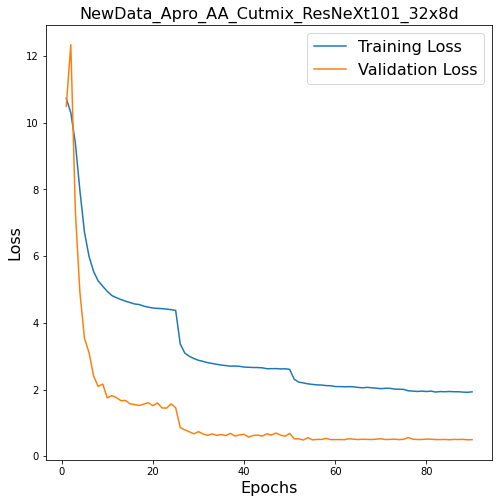

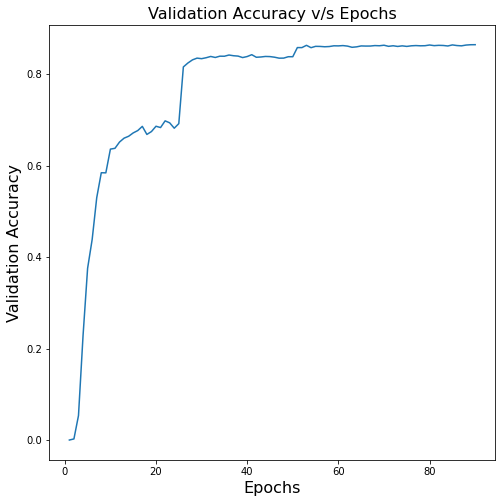

In [18]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'NewData_Apro_AA_Cutmix_ResNeXt101_32x8d')
plot_acc(epoch, v_acc)


In [ ]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

In [19]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

Validation Loss: 0.4974	Top 1 Validation Accuracy: 0.8643
Accuracy:defaultdict(<class 'int'>, {'Top 1 Accuracy': 86.42702768829263, 'Top 5 Accuracy': 98.64413000040778, 'Top 10 Accuracy': 99.23745055662032, 'Top 20 Accuracy': 99.53037284725904, 'Top 30 Accuracy': 99.63979393494543, 'Top 50 Accuracy': 99.74173904769673, 'Top 100 Accuracy': 99.83009147874785})	


**Fine-tune using Label Smoothing Cross entropy loss**

In [13]:
from trainer import train, test_classify, eval_classify
from label_smoothing import LabelSmoothingCrossEntropy

## Loss Function
criterion = LabelSmoothingCrossEntropy()


# Optimizer
optimizer_ls = torch.optim.SGD(model.parameters(), lr=0.00005, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 25, gamma = 0.1)

# Epochs
num_Epochs = 5


#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)

In [15]:
writer = SummaryWriter()
train(model, train_dataloader, validation_dataloader, criterion, optimizer_ls, lr_scheduler, modelpath, writer, device, epochs= num_Epochs)

writer.flush()
writer.close()

loss 1.799258632659912
loss 3.60006702542305
loss 5.399953892230988
loss 7.204748657941818
loss 9.007300528287887
loss 10.806632572412491
loss 12.603097579479218
loss 14.39781732559204
loss 16.19654513478279
loss 17.99356863498688
loss 19.789346923828123
loss 21.59025391459465
loss 23.396574788093567
loss 25.195338928699492
loss 26.998297612667084
loss 28.80042635798454
loss 30.599844102859496
loss 32.39181084752083
loss 34.2046596467495
loss 36.005369755029676
loss 37.79795155882835
loss 39.594953135252
loss 41.39225044846535
loss 43.19655650019646
loss 44.99705384492874
loss 46.794407538175584
loss 48.59371188044548
loss 50.39833599328995
loss 52.20157232761383
loss 54.00468543410301
loss 55.81589411020279
loss 57.62008223176002
loss 59.42370941519737
loss 61.22548110842705
loss 63.026123200654986
loss 64.82493898034096
loss 66.6223119199276
loss 68.42108634710311
loss 70.22112751603126
loss 72.0297906255722
loss 73.82918095707893
loss 75.62575507640838
loss 77.43271194458008
Epoch: 

In [1]:
!nvidia-smi

Sat Nov  7 19:33:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 42%   65C    P2   239W / 280W |  23873MiB / 24220MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 79%   85C    P2   128W / 280W |  23946MiB / 24220MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T